# Uncertainty Analysis

This section demonstrates the use of the Monte Carlo sampling (MCS) method for forward propagation of uncertainty. In uncertainty analysis, it is of interest to quantify how uncertain design variables or parameters of a problem affect the quantity of interest (QoI) for a given system. This is done by sampling the distribution of the uncertain variables or parameters using a sampling method and calculating the QoI for a large number of samples. The required statistics (mean, standard deviation, reliability) can then be calculated from the QoI values that are generated using MCS. In the context of optimization, the statistics of interest are typically the mean and standard deviation of the objective function and the reliability of the constraint. 

To illustrate the ideas of uncertainty analysis, consider a problem with the following objective and constraint

$$Y = f(\textbf{x}) = x_1^2 + 2x_2^2 + 3x_3^2$$
$$g(\textbf{x}) = x_1 + x_2 + x_3 - 3.5 \leq 0$$

In this problem, $x_1$ is deterministic and other two variables are normally distributed with standard deviations: $\sigma_2 = 0.06$ and $\sigma_3 = 0.2$. For the following analysis, the design variable values used are $x = [1,1,1]^T$. This means that $x_1 = 1$, $x_2 \sim \mathcal{N}(1,0.06)$, and $x_3 \sim \mathcal{N}(1, 0.2)$.

The first block of code below imports the required packages to perform the uncertainty analysis.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm
from time import time
from smt.sampling_methods import LHS
from scipy.stats.qmc import Halton, scale

## Calculation of statistics (mean and standard deviation) of objective function

This subsection will discuss the calculation of the statistics of the objective function based on the uncertain design variables. At the start, the general idea of the MCS method will be demonstrated where a large number of samples will be drawn from the distributions of the random variables using random sampling and Halton sequences. The objective function statistics and distribution will be calculated based on the samples that are generated the value of the objective function for those samples. However, when using the MCS method it is also important to determine the minimum number of samples that can accurately obtain the statistics of a model to reduce computational cost. This is done by varying the number of samples from small to large values and observing the change in the mean and standard deviation. The minimum number of samples for which there is no significant change in the estimated mean and standard deviation from the previous number of samples used can be used to obtain the statistics of the objective function. Typically, one would start the analysis by performing the convergence of the MCS method to find the minimum number of samples. 

The next block of code defines the objective function and constraint of the problem. 

In [3]:
def function(x1, x2, x3):
    """
        Function for computing objective values
    """
    
    value = x1**2 + 2*x2**2 + 3*x3**2
    
    return value

def constraint(x1, x2, x3):
    """
        Function for computing constraint values
    """

    value = x1 + x2 + x3 - 3.5

    return value

### MCS method for a large number of samples

The first demonstration of MCS is with **random sampling**. The block of code below defines random variables for $x_2$ and $x_3$, and performs MCS with 1,000,000 random samples for computing mean, standard deviation, and the output distribution.

Estimated mean (true): 6.12930134987835
Estimated standard deviation (true): 1.236068224197124


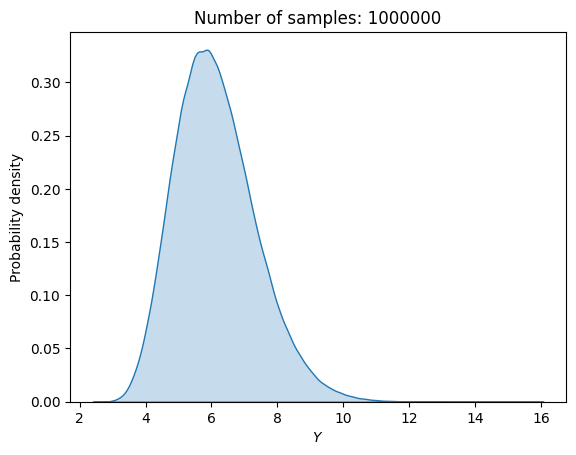

In [4]:
# Defining random variables
rv_x2 = norm(loc=1, scale=0.06)
rv_x3 = norm(loc=1, scale=0.2)
num_samples = 1000000

x1 = 1
x2 = rv_x2.rvs(size=num_samples)
x3 = rv_x3.rvs(size=num_samples)

f_random_ = function(x1, x2, x3)

sns.kdeplot(x=f_random_, fill=True)
plt.ylabel("Probability density")
plt.xlabel("$Y$")
plt.title("Number of samples: {}".format(num_samples))

print("Estimated mean (true): {}".format(np.mean(f_random_)))
print("Estimated standard deviation (true): {}".format(np.std(f_random_)))

From the above MCS with random sampling, the $\mu$ is 6.13 and $\sigma$ is 1.23. This distribution is slightly asymmetric and has a longer right tail.

In the second demonstration of MCS, the samples from the distribution will be drawn according to **Halton sequences**. In the context of sampling distributions, Halton sequences generated on a unit hypercube (values are generated between the bounds of 0 and 1) represent probabilities of the occurrence of a realization of a random design variable or parameter. These probabilities can then be transformed into the realizations of the random design variable or parameter using the inverse CDF function of the distribution of the random design variable or parameter. In this way, samples can be drawn from the distributions of the uncertain variables and parameters and MCS can be performed.    

The block of code below demonstrates this approach of using Halton sequences to perform MCS. Like the previous example of random sampling, the mean, standard deviation and output distribution are computed using 1,000,000 samples. 


Estimated mean (Halton): 6.12716999446928
Estimated standard deviation (Halton): 1.235459444685999


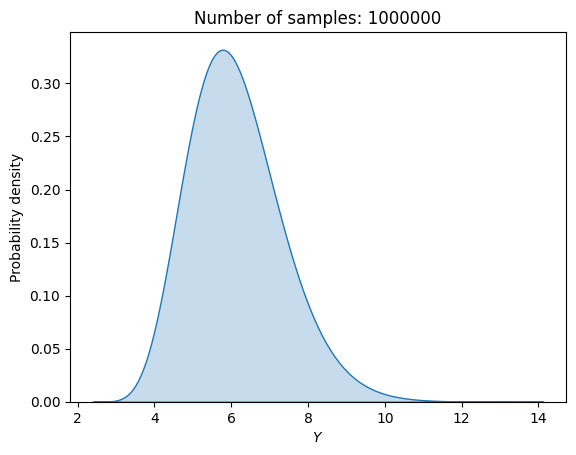

In [5]:
# Defining the Halton sampler
halton_sampler = Halton(d=2, scramble=False) 
# scramble is set to false to avoid Owen scrambling which is used to create non-deterministic Halton sequences

num_samples = 1000000

# Generating halton sequence samples and transforming them according to the distributions of the random variables
x1 = 1
x_halton = halton_sampler.random(n = num_samples)
x_halton = x_halton[1:,:] # Dropping the first element [0,0] of the Halton sequence since inverse CDF of 0 will be inf
x2_halton = rv_x2.ppf(x_halton[:,0])
x3_halton = rv_x3.ppf(x_halton[:,1])

f_halton = function(x1, x2_halton, x3_halton)

sns.kdeplot(x=f_halton, fill=True)
plt.ylabel("Probability density")
plt.xlabel("$Y$")
plt.title("Number of samples: {}".format(num_samples))

print("Estimated mean (Halton): {}".format(np.mean(f_halton)))
print("Estimated standard deviation (Halton): {}".format(np.std(f_halton)))

The $\mu$ and $\sigma$ obtained using Halton sequences closely matches the values obtained using random sampling. The output distribution is also a good match for the one obtained using random sampling.

### Convergence of the MCS method

Now, MCS will be performed using **random sampling**, **Latin Hypercube sampling (LHS)** and **Halton sequences** using a varied number of samples drawn from the distribution. The previous analysis used a fixed number of samples to perform the MCS but in the following analysis, the number of samples used for the MCS will be varied and the statistics will be calculated at every number of samples. In this case, LHS and Halton sequences are used to generate samples between the bounds of 0 and 1. As mentioned previously, these values are treated as probabilities and the inverse CDF of the random variables is used to draw samples from the distribution based on the values of these probabilities.  

In [6]:
# Defining different samples sizes for MCS
samples = np.logspace(1, 4, 20, dtype=int)

# Defining the LHS sampler
lhs_sampler = LHS(xlimits=np.array([[0.0,1.0], [0.0,1.0]]), criterion="ese")

# Storing statistics
mean_lhs = []
sigma_lhs = []
mean_halton = []
sigma_halton = []
mean_random = []
sigma_random = []

# Storing the function values
F_lhs = []
F_random = []
F_halton = []

for sample in samples:
    
    # LHS sampling
    x_lhs = lhs_sampler(sample)
    x2_lhs = rv_x2.ppf(x_lhs[:,0])
    x3_lhs = rv_x3.ppf(x_lhs[:,1])
    x1 = 1
    f_lhs = function(x1, x2_lhs, x3_lhs)
    mean_lhs.append(np.mean(f_lhs))
    sigma_lhs.append(np.std(f_lhs))
    F_lhs.append(f_lhs)

    # Halton sampling
    x_halton = halton_sampler.random(n = sample)
    if sample == samples[0]:
        x_halton = x_halton[1:,:] # Dropping the first element [0,0] of the Halton sequence since inverse CDF of 0 will be inf
    x2_halton = rv_x2.ppf(x_halton[:,0])
    x3_halton = rv_x3.ppf(x_halton[:,1])
    f_halton = function(x1, x2_halton, x3_halton)
    mean_halton.append(np.mean(f_halton))
    sigma_halton.append(np.std(f_halton))
    F_halton.append(f_halton)
    
    # Random sampling
    x2 = rv_x2.rvs(size=sample)
    x3 = rv_x3.rvs(size=sample)
    f_random = function(x1, x2, x3)
    mean_random.append(np.mean(f_random))
    sigma_random.append(np.std(f_random))
    F_random.append(f_random)

The next block of code plots the convergence history of the MCS with different number of samples. The convergence history plots the convergence of the mean and standard deviation versus the number of samples used in the MCS. The relative change in the mean and standard deviation versus the number of samples is also plotted. A tolerance for the relative change in the statistics can be used to determine when the MCS has converged. This can be used to determine the number of MCS samples required to accurately determine the statistics of the objective function.

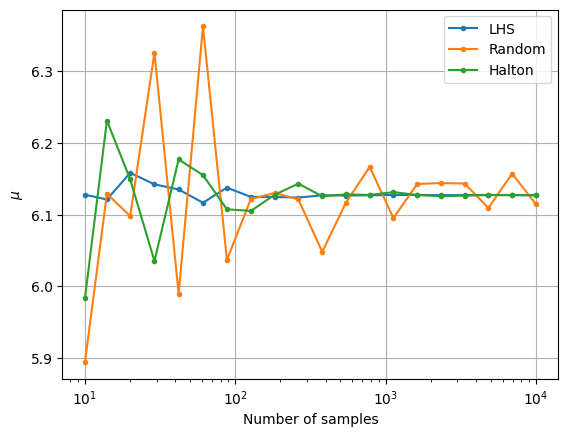

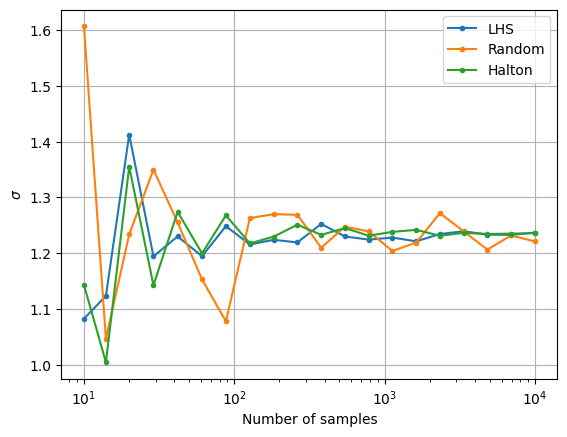

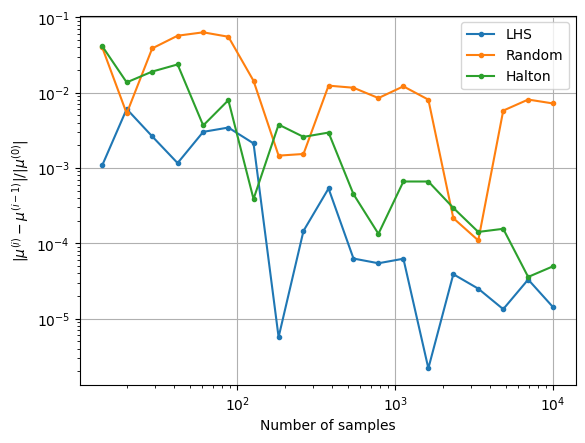

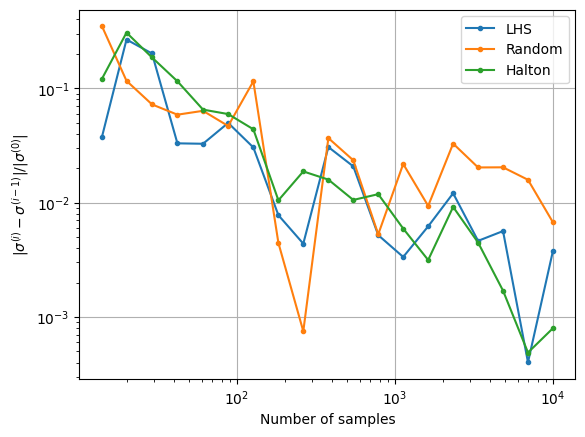

In [8]:
fig, ax = plt.subplots()
ax.plot(samples, mean_lhs, marker=".", label="LHS")
ax.plot(samples, mean_random, marker=".", label="Random")
ax.plot(samples, mean_halton, marker=".", label="Halton")
ax.legend()
ax.grid()
ax.set_ylabel(r"$\mu$")
ax.set_xlabel("Number of samples")
ax.set_xscale("log")

fig, ax = plt.subplots()
ax.plot(samples, sigma_lhs, marker=".", label="LHS")
ax.plot(samples, sigma_random, marker=".", label="Random")
ax.plot(samples, sigma_halton, marker=".", label="Halton")
ax.legend()
ax.grid()
ax.set_ylabel(r"$\sigma$")
ax.set_xlabel("Number of samples")
ax.set_xscale("log")

conv_mean_lhs = np.zeros(len(samples)-1)
conv_mean_random = np.zeros(len(samples)-1)
conv_mean_halton = np.zeros(len(samples)-1)
conv_sigma_lhs = np.zeros(len(samples)-1)
conv_sigma_random = np.zeros(len(samples)-1)
conv_sigma_halton = np.zeros(len(samples)-1)

for i in range(len(samples)-1):
    conv_mean_lhs[i] = np.abs(mean_lhs[i+1] - mean_lhs[i]) / np.abs(mean_lhs[0])
    conv_mean_random[i] = np.abs(mean_random[i+1] - mean_random[i]) / np.abs(mean_random[0])
    conv_mean_halton[i] = np.abs(mean_halton[i+1] - mean_halton[i]) / np.abs(mean_halton[0])
    conv_sigma_lhs[i] = np.abs(sigma_lhs[i+1] - sigma_lhs[i]) / np.abs(sigma_lhs[0])
    conv_sigma_random[i] = np.abs(sigma_random[i+1] - sigma_random[i]) / np.abs(sigma_random[0])
    conv_sigma_halton[i] = np.abs(sigma_halton[i+1] - sigma_halton[i]) / np.abs(sigma_halton[0])
    
fig, ax = plt.subplots()
ax.plot(samples[1:], conv_mean_lhs, label="LHS", marker=".")
ax.plot(samples[1:], conv_mean_random, label="Random", marker=".")
ax.plot(samples[1:], conv_mean_halton, label="Halton", marker=".")
ax.legend()
ax.grid()
ax.set_ylabel(r"$ |\mu^{(i)} - \mu^{(i-1)}| / |\mu^{(0)}|$")
ax.set_xlabel("Number of samples")
ax.set_xscale("log")
ax.set_yscale("log")

fig, ax = plt.subplots()
ax.plot(samples[1:], conv_sigma_lhs, label="LHS", marker=".")
ax.plot(samples[1:], conv_sigma_random, label="Random", marker=".")
ax.plot(samples[1:], conv_sigma_halton, label="Halton", marker=".")
ax.legend()
ax.grid()
ax.set_ylabel(r"$ |\sigma^{(i)} - \sigma^{(i-1)}| / |\sigma^{(0)}|$")
ax.set_xlabel("Number of samples")
ax.set_xscale("log")
ax.set_yscale("log")

Notice that as the number of samples increase, the $\mu$ and $\sigma$ also converge to the value obtained from MCS in the previous block of code. The above convergence plots show the benefit of using LHS and Halton sequences to sample the distribution as compared to using random sampling. MCS performed using LHS and Halton sequences tends to converge faster to the known values of $\mu$ and $\sigma$. This can be deduced from the quick reduction in the relative change of the mean and standard deviation that is brought by using the LHS and Halton sequence sampling method. It is also deduced from the variation of mean and standard deviation with the number of samples as the values converge to those obtained from performing MCS using a large number of samples. This means a lower number of samples must be drawn from the distribution and evaluated to calculate the statistics. This reduces the computational cost of performing the uncertainty analysis.

A similar convergence history can also be plotted for the output distribution of the objective function. This is done in the next code block. This convergence history shows that the output distribution closely matches the true distribution as the number of samples increases. Here, the distribution obtained using random sampling and $10^6$ MCS samples in an earlier code block is treated as the true distribution.

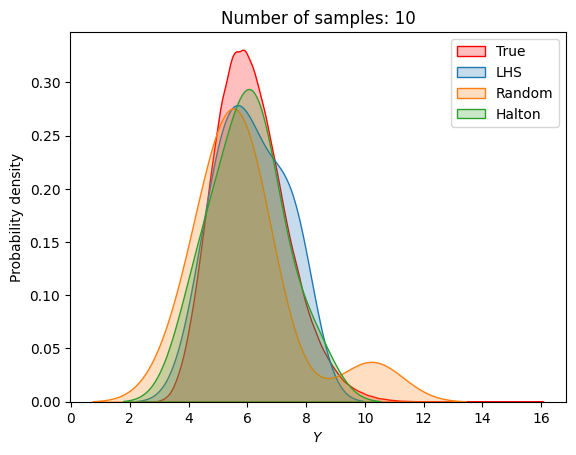

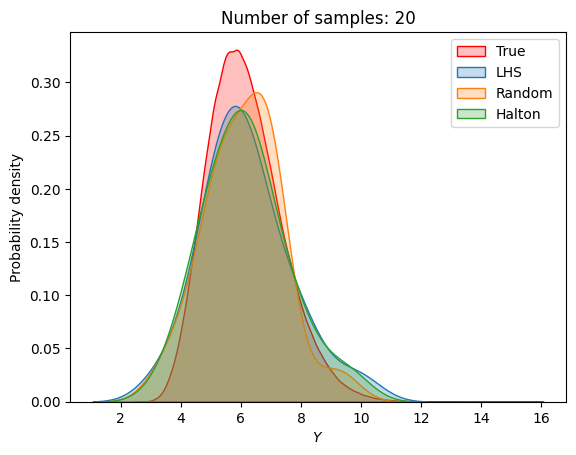

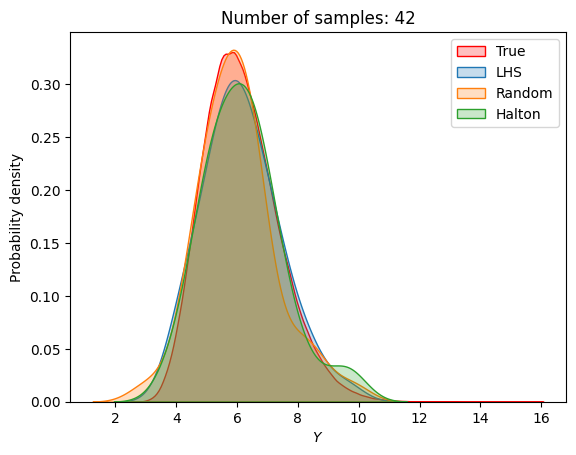

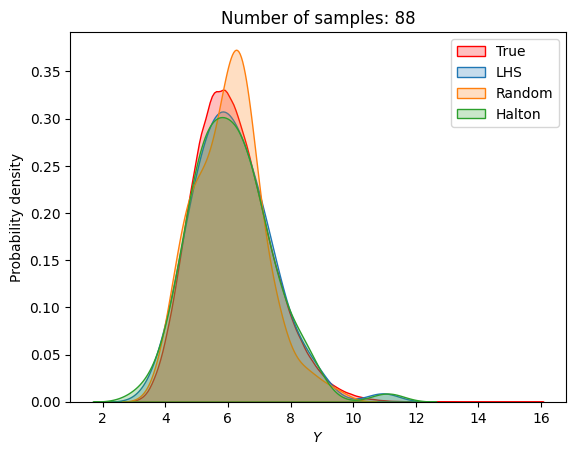

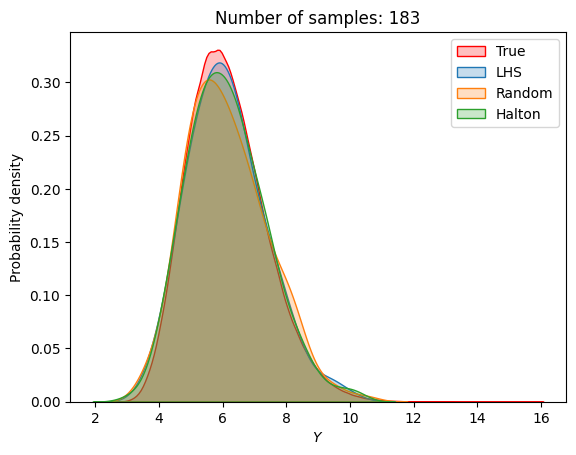

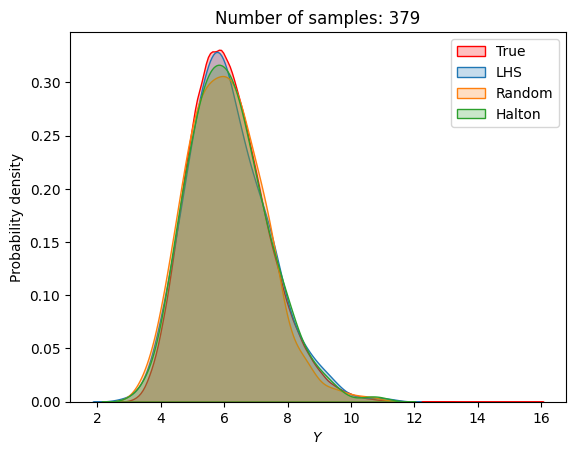

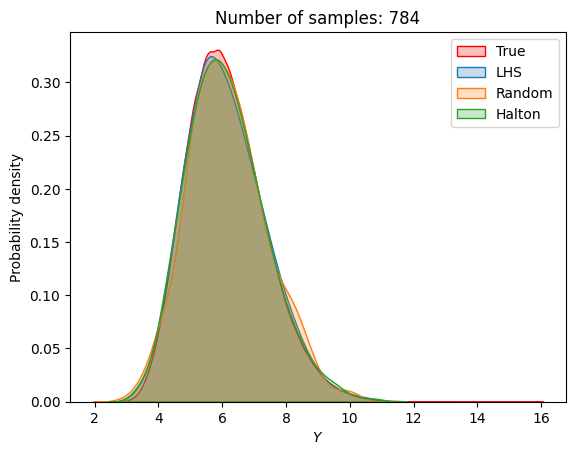

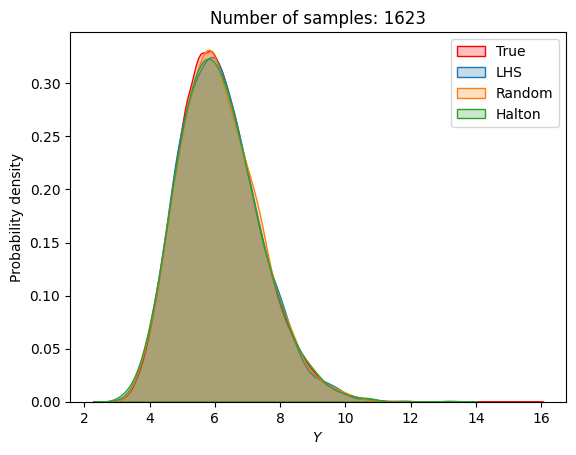

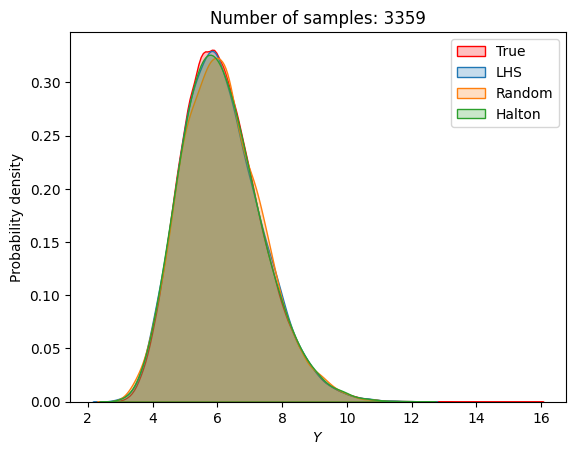

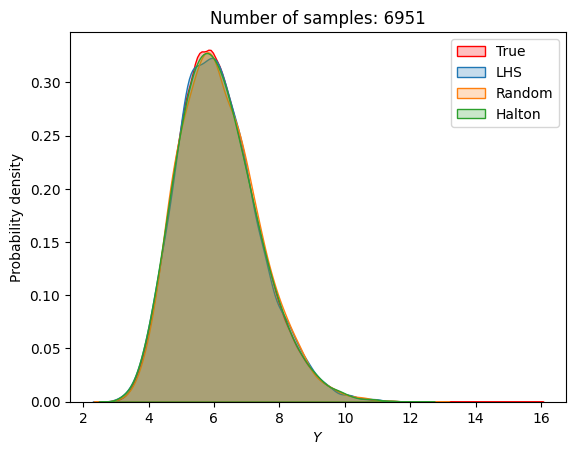

In [9]:
for i in range(0, len(samples), 2):
    fig, ax = plt.subplots()
    sns.kdeplot(x=f_random_, fill=True, color = "red",label = 'True')
    sns.kdeplot(x=F_lhs[i], fill=True, label = 'LHS')
    sns.kdeplot(x=F_random[i], fill=True, label = 'Random')
    sns.kdeplot(x=F_halton[i], fill=True, label = 'Halton')
    plt.legend()
    plt.ylabel("Probability density")
    plt.xlabel("$Y$")
    plt.title("Number of samples: {}".format(samples[i]))

## Probability of feasibility of a constraint

When working with uncertainty in design variables or parameters for an optimization problem, the probability of feasibility of a constraint
is of interest to a designer. The probability of feasibility of the constraint used as an example in this section can be calculated using MCS. The distributions of the uncertain variables can be sampled using the methods shown previously and for each sample, the value of the constraint can be calculated. Once all the samples are evaluated, the required probability can be calculated by simply dividing the number of samples that satisfy the constraint by the total number of samples.

$$\text{Pr}(g(\textbf{x}) \leq 0) \approx \frac{\text{number of feasible samples}}{\text{total number of samples}}$$

Similar to the previous section, the next block of code uses random sampling and a large number of MCS samples to calculate the true probability of feasibility of the constraint.

In [10]:
num_samples = 1000000

x1 = 1
x2 = rv_x2.rvs(size=num_samples)
x3 = rv_x3.rvs(size=num_samples)

g_random_ = constraint(x1, x2, x3)

print("Estimated probability of feasibility (true): {}".format(len(g_random_[g_random_<=0])/num_samples))

Estimated probability of feasibility (true): 0.991639


The next block of code uses the LHS and Halton sequence sampling methods along with random sampling to calculate the reliability of the constraint. The number of samples used for MCS is varied and the variation of the reliability with number of samples is plotted to visualize the convergence.  

In [11]:
# Defining different samples sizes for MCS
samples = np.logspace(1, 4, 20, dtype=int)

# Storing reliabilities
p_lhs = []
p_halton = []
p_random = []

for sample in samples:

    # LHS sampling
    x_lhs = lhs_sampler(sample)
    x2_lhs = rv_x2.ppf(x_lhs[:,0])
    x3_lhs = rv_x3.ppf(x_lhs[:,1])
    x1 = 1
    g_lhs = constraint(x1, x2_lhs, x3_lhs)
    p_lhs.append(len(g_lhs[g_lhs<=0])/sample)

    # Halton sampling
    x_halton = halton_sampler.random(n = sample)
    if sample == samples[0]:
        x_halton = x_halton[1:,:] # Dropping the first element [0,0] of the Halton sequence since inverse CDF of 0 will be inf
    x2_halton = rv_x2.ppf(x_halton[:,0])
    x3_halton = rv_x3.ppf(x_halton[:,1])
    g_halton = constraint(x1, x2_halton, x3_halton)
    p_halton.append(len(g_halton[g_halton<=0])/sample)
    
    # Random sampling
    x2 = rv_x2.rvs(size=sample)
    x3 = rv_x3.rvs(size=sample)
    g_random = constraint(x1, x2, x3)
    p_random.append(len(g_random[g_random<=0])/sample)

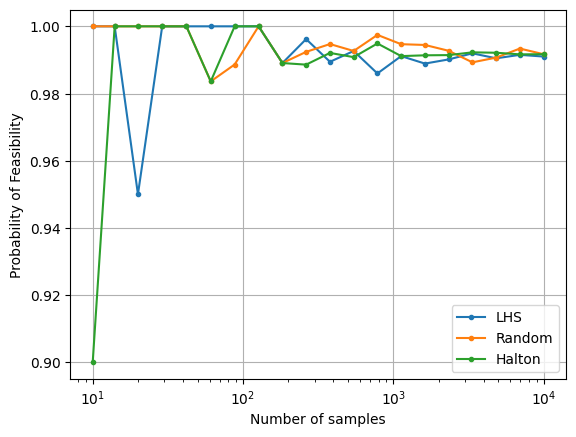

In [12]:
fig, ax = plt.subplots()
ax.plot(samples, p_lhs, marker=".", label="LHS")
ax.plot(samples, p_random, marker=".", label="Random")
ax.plot(samples, p_halton, marker=".", label="Halton")
ax.legend()
ax.grid()
ax.set_ylabel("Probability of Feasibility")
ax.set_xlabel("Number of samples")
ax.set_xscale("log")